# Masterthesis
## Regression

#### Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import category_encoders as ce
from tensorflow.python.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import RandomizedSearchCV, KFold 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
import matplotlib.pyplot as plt
from scipy import stats

Using TensorFlow backend.


In [2]:
na_values = ['nan', 'N/A', 'NaN', 'NaT']

In [3]:
df = pd.read_csv('resources/accident_data.csv', sep=";", na_values=na_values, index_col=False, dtype = {"STATE" : "str", "TYPE" : "str", "TYPEQ" : "str", "WEATHER" : "str", "VISIBLTY" : "str", "SPD_TOO_HIGH" : "str"})

In [4]:
df=df.dropna(subset=['WEATHER', 'VISIBLTY'])
pd.set_option('display.max_columns', 500)
#df.head(50)

## Vorbereitungen

Festlegen der abhängigen Variablen X und der vorherzusagenden Variable y

In [5]:
x_data = df[['TEMP', 'TYPEQ', 'TRKCLAS', 'ACCCAUSE_LVL1', 'ACCCAUSE_LVL2', 'ACCAUSE', 'YEAR4', 'STATE', 'MONTH', 'LOCOMOTIVES1', 'LOADF1', 'LOADP1', 'EMPTYF1', 'EMPTYP1','LOCOMOTIVES2', 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'TONS', 'TEMP_CLUSTER', 'SPEED', 'ACCCAUSE_LVL1', 'TYPE', 'EQUIPMENT_TYPE', 'TYPTRK', 'VISIBLTY', 'WEATHER', 'SPD_TOO_HIGH', 'ACCTYPE', 'ACCIDENT_TYPE', 'Jahreszeit']]

In [6]:
y = df['INFRASTRUCTURE_DMG']

In [7]:
print(x_data.isnull().sum())

TEMP              0
TYPEQ             0
TRKCLAS           0
ACCCAUSE_LVL1     0
ACCCAUSE_LVL2     0
ACCAUSE           0
YEAR4             0
STATE             0
MONTH             0
LOCOMOTIVES1      0
LOADF1            0
LOADP1            0
EMPTYF1           0
EMPTYP1           0
LOCOMOTIVES2      0
LOADF2            0
EMPTYF2           0
LOADP2            0
EMPTYP2           0
TONS              0
TEMP_CLUSTER      0
SPEED             0
ACCCAUSE_LVL1     0
TYPE              0
EQUIPMENT_TYPE    0
TYPTRK            0
VISIBLTY          0
WEATHER           0
SPD_TOO_HIGH      0
ACCTYPE           0
ACCIDENT_TYPE     0
Jahreszeit        0
dtype: int64


## Umwandlung der kategorialen Merkmale und Normalisierung der kontinuierlichen Merkmale

In [8]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem One Hot Encoder 
# x = kategoriale Merkmale
def prepare_inputs_One_Hot(x):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(x)
    x_enc = encoder.transform(x)
    return x_enc

In [9]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Ordinal Encoder 
# x = kategoriale Merkmale
def prepare_inputs_Ordinal(x):
    encoder = OrdinalEncoder()
    encoder.fit(x)
    x_enc = encoder.transform(x)
    return x_enc

In [10]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Binary Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale
def prepare_inputs_Binary(x, cats):
    encoder = ce.BinaryEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats])
    df_bin = encoder.transform(x[cats])
    return df_bin

In [11]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Target Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale, Y = unabhägiges Merkmal
def prepare_inputs_Target(x, Y, cats, smoothing):
    encoder = ce.TargetEncoder(cols=cats, return_df=True, min_samples_leaf = 5, smoothing=smoothing)
    encoder.fit(x[cats], Y)
    df_te = encoder.transform(x[cats], Y)
    return df_te

In [12]:
# Funktion zur Umwandlung der kategorialen Merkmale mit dem Leave One Out Encoder
# x = Datensatz, cats = Liste mit Spaltenüberschriften der kategorialen Merkmale, Y = unabhägiges Merkmal
def prepare_inputs_Leave_One_Out(x, Y, cats):
    encoder = ce.LeaveOneOutEncoder(cols=cats, return_df=True)
    encoder.fit(x[cats], Y)
    df_loo = encoder.transform(x[cats], Y)
    return df_loo

### Merkmale, die betrachtet werden





In [13]:
#cat = ['TEMP_CLUSTER', 'Jahreszeit', 'EQUIPMENT_TYPE', 'ACCIDENT_TYPE', 'TYPTRK', 'WEATHER', 'VISIBLTY', 'STATE', 'ACCCAUSE_LVL1', 'SPD_TOO_HIGH', 'ACCTYPE', 'TRKCLAS']

In [14]:
#con = ['SPEED', 'TONS', 'YEAR4', 'LOADF1', 'EMPTYF1', 'LOADP1', 'EMPTYP1', 'LOCOMOTIVES1', 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'LOCOMOTIVES2']

In [15]:
cat = ['TEMP_CLUSTER', 'Jahreszeit', 'EQUIPMENT_TYPE', 'ACCIDENT_TYPE', 'ACCTYPE', 'TRKCLAS']

In [16]:
con = ['SPEED', 'TONS', 'YEAR4', 'LOADF1', 'EMPTYF1', 'LOADP1', 'EMPTYP1', 'LOCOMOTIVES1' , 'LOADF2', 'EMPTYF2', 'LOADP2', 'EMPTYP2', 'LOCOMOTIVES2']

In [17]:
#x_enc_cat = prepare_inputs_Ordinal(x_data[cat])

In [18]:
x_enc_cat = prepare_inputs_One_Hot(x_data[cat])

In [19]:
#x_enc_cat = prepare_inputs_Binary(x_data, cat)

In [20]:
#x_enc_cat = prepare_inputs_Target(x_data, y, cat, 1.0)

In [21]:
#x_enc_cat = prepare_inputs_Target(x_data, y, cat, 10)

In [22]:
#x_enc_cat = prepare_inputs_Leave_One_Out(x_data, y, cat)

In [23]:
# Normalisierung der kontinuierlichen Merkmale mit dem StandardScaler oder dem MinMaxScaler
#cs = MinMaxScaler().fit(x_data[con])
cs = StandardScaler().fit(x_data[con])
x_enc_con = cs.transform(x_data[con])
#x_enc_con = x_data[con]

In [24]:
#cs_y = MinMaxScaler().fit(y.values.reshape(-1, 1))
#cs_y = StandardScaler().fit(y.values.reshape(-1, 1))
#y = cs_y.transform(y.values.reshape(-1, 1))

#### Zusammenfügen der kategorialen und kontinuierlichen Merkmale

In [25]:
X_Data = np.hstack([x_enc_cat, x_enc_con])

#### Aufteilen der Merkmale in Trainings- und Testdaten
70% Trainingsdaten & 30 % Testdaten
random_state: Kontrolliert die Zufallsverteilung -> Es werden immer die gleichen Werte Trainings- und Testdaten zugeteilt. Sonst könnte es zu Abweichungen bei den Ergebnissen des Modells kommen

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_Data, y, test_size=0.3, random_state=42)

In [27]:
n_features = X_train.shape[1]

## Sequential regression model

In [28]:
def create_model(learning_rate = 0.01, activation = 'relu'):
    seq_model = Sequential()
    dropout = 0
    opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
     
    seq_model.add(Dense(int(n_features*2/3), activation=activation, input_shape=(n_features,)))
    seq_model.add(BatchNormalization())
    seq_model.add(Dropout(dropout))
    seq_model.add(Dense(int(n_features*2/3*2/3), activation=activation))
    #seq_model.add(BatchNormalization())
    #seq_model.add(Dense(128, activation=activation))
    #seq_model.add(Dropout(dropout))
    #seq_model.add(Dense(64, activation=activation))
    #seq_model.add(Dropout(dropout))
    #seq_model.add(Dense(32, activation=activation))
    #seq_model.add(Dropout(dropout))
    seq_model.add(Dense(1))
    seq_model.compile(optimizer=opt, loss='mse', metrics=['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])
    return seq_model

In [29]:
model = KerasRegressor(build_fn = create_model)

In [30]:
params = {'activation': ["relu", "tanh", "sigmoid", "selu", "softmax"],'batch_size': [32, 64], 'epochs': [50, 100, 300, 500, 1000],'learning_rate': [0.1, 0.01, 0.001, 0.0001]}

In [31]:
random_search = RandomizedSearchCV(model, param_distributions = params,cv = KFold(10))

In [32]:
#random_search_results = random_search.fit(X_train, y_train)

In [33]:
#print("Best Score: ",random_search_results.best_score_,"and Best Params: ",random_search_results.best_params_)

### Regression Allgemein

In [34]:
epochs = 150

In [35]:
learning_rate = 0.01

In [36]:
activation = 'relu'

In [37]:
dropout = 0

In [38]:
metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae']

In [39]:
opt = tf.keras.optimizers.Adam()
#opt = tf.keras.optimizers.Adamax()
#opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
#opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
#opt = tf.keras.optimizers.Ftrl(learning_rate=learning_rate)
#opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
#opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)



## Sequential Regression with Keras

In [40]:
seq_model = Sequential()

seq_model.add(Dense(512, activation=activation, input_shape=(n_features,)))
#seq_model.add(BatchNormalization())
seq_model.add(Dropout(dropout))
seq_model.add(Dense(256, activation=activation))
seq_model.add(BatchNormalization())
#seq_model.add(Dense(128, activation=activation))
#seq_model.add(Dropout(dropout))
#seq_model.add(Dense(64, activation=activation))
#seq_model.add(Dropout(dropout))
#seq_model.add(Dense(32, activation=activation))
#seq_model.add(Dropout(dropout))
seq_model.add(Dense(1))
seq_model.compile(optimizer=opt, loss='mse', metrics=metrics)

In [41]:
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               24576     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 156,161
Trainable params: 156,161
Non-trainable params: 0
_________________________________________________________________


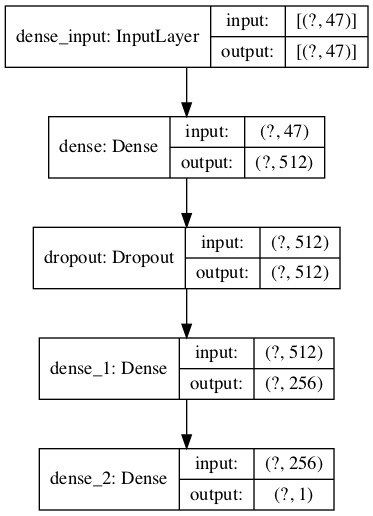

In [42]:
plot_model(seq_model, 'Images/Sequential Regression Model.png', show_shapes=True)

In [43]:
es = EarlyStopping(monitor='val_loss', patience=5)

In [44]:
history = seq_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, batch_size=32)

Epoch 1/150
1385/1385 [==============================] - 3s 2ms/step - loss: 14269355008.0000 - mse: 14269355008.0000 - rmse: 119454.4062 - mae: 56463.7695 - val_loss: 8692418560.0000 - val_mse: 8692418560.0000 - val_rmse: 93233.1406 - val_mae: 45755.8281
Epoch 2/150
1385/1385 [==============================] - 3s 2ms/step - loss: 7886804992.0000 - mse: 7886804992.0000 - rmse: 88807.6875 - mae: 41961.6133 - val_loss: 6974118400.0000 - val_mse: 6974118400.0000 - val_rmse: 83511.1875 - val_mae: 39298.4219
Epoch 3/150
1385/1385 [==============================] - 2s 2ms/step - loss: 7076121088.0000 - mse: 7076121088.0000 - rmse: 84119.6797 - mae: 39344.9062 - val_loss: 6634473984.0000 - val_mse: 6634473984.0000 - val_rmse: 81452.2812 - val_mae: 37765.7891
Epoch 4/150
1385/1385 [==============================] - 3s 2ms/step - loss: 6825289728.0000 - mse: 6825289728.0000 - rmse: 82615.3125 - mae: 38662.8477 - val_loss: 6498345984.0000 - val_mse: 6498345984.0000 - val_rmse: 80612.3203 - val_m

1385/1385 [==============================] - 3s 2ms/step - loss: 6191039488.0000 - mse: 6191039488.0000 - rmse: 78683.1562 - mae: 36783.7656 - val_loss: 6069890560.0000 - val_mse: 6069890560.0000 - val_rmse: 77909.5000 - val_mae: 36470.5664
Epoch 34/150
1385/1385 [==============================] - 3s 2ms/step - loss: 6182033408.0000 - mse: 6182033408.0000 - rmse: 78625.9062 - mae: 36804.4023 - val_loss: 6079768064.0000 - val_mse: 6079768064.0000 - val_rmse: 77972.8672 - val_mae: 36225.5156
Epoch 35/150
1385/1385 [==============================] - 4s 3ms/step - loss: 6167197184.0000 - mse: 6167197184.0000 - rmse: 78531.5078 - mae: 36776.4922 - val_loss: 6076140544.0000 - val_mse: 6076140544.0000 - val_rmse: 77949.6016 - val_mae: 36079.8438
Epoch 36/150
1385/1385 [==============================] - 3s 2ms/step - loss: 6163348992.0000 - mse: 6163348992.0000 - rmse: 78507.0000 - mae: 36702.6641 - val_loss: 6068152320.0000 - val_mse: 6068152320.0000 - val_rmse: 77898.3438 - val_mae: 37186.48

1385/1385 [==============================] - 2s 2ms/step - loss: 5995187712.0000 - mse: 5995187712.0000 - rmse: 77428.5938 - mae: 36348.8516 - val_loss: 6004234752.0000 - val_mse: 6004234752.0000 - val_rmse: 77487.0000 - val_mae: 36288.0977
Epoch 66/150
1385/1385 [==============================] - 3s 2ms/step - loss: 5982854144.0000 - mse: 5982854144.0000 - rmse: 77348.9141 - mae: 36386.7617 - val_loss: 6018174464.0000 - val_mse: 6018174464.0000 - val_rmse: 77576.8906 - val_mae: 36360.9219
Epoch 67/150
1385/1385 [==============================] - 3s 2ms/step - loss: 5977311744.0000 - mse: 5977311744.0000 - rmse: 77313.0781 - mae: 36333.6680 - val_loss: 6014841344.0000 - val_mse: 6014841344.0000 - val_rmse: 77555.4062 - val_mae: 36054.4609
Epoch 68/150
1385/1385 [==============================] - 2s 2ms/step - loss: 5977524224.0000 - mse: 5977524224.0000 - rmse: 77314.4531 - mae: 36330.2148 - val_loss: 6009263616.0000 - val_mse: 6009263616.0000 - val_rmse: 77519.4375 - val_mae: 36205.45

1385/1385 [==============================] - 3s 2ms/step - loss: 5848992768.0000 - mse: 5848992768.0000 - rmse: 76478.7109 - mae: 36083.4727 - val_loss: 5985662464.0000 - val_mse: 5985662464.0000 - val_rmse: 77367.0625 - val_mae: 36220.8633
Epoch 98/150
1385/1385 [==============================] - 3s 2ms/step - loss: 5858603008.0000 - mse: 5858603008.0000 - rmse: 76541.5078 - mae: 36130.8750 - val_loss: 5980729344.0000 - val_mse: 5980729344.0000 - val_rmse: 77335.1719 - val_mae: 36198.2578
Epoch 99/150
1385/1385 [==============================] - 3s 2ms/step - loss: 5839375872.0000 - mse: 5839375872.0000 - rmse: 76415.8125 - mae: 36049.5039 - val_loss: 5990551552.0000 - val_mse: 5990551552.0000 - val_rmse: 77398.6562 - val_mae: 35954.0078
Epoch 100/150
1385/1385 [==============================] - 3s 2ms/step - loss: 5829612544.0000 - mse: 5829612544.0000 - rmse: 76351.8984 - mae: 36056.7539 - val_loss: 6011758592.0000 - val_mse: 6011758592.0000 - val_rmse: 77535.5312 - val_mae: 35988.9

1385/1385 [==============================] - 3s 2ms/step - loss: 5655516160.0000 - mse: 5655516160.0000 - rmse: 75203.1641 - mae: 35622.3359 - val_loss: 5959227392.0000 - val_mse: 5959227392.0000 - val_rmse: 77196.0312 - val_mae: 35883.3750
Epoch 130/150
1385/1385 [==============================] - 3s 2ms/step - loss: 5655655936.0000 - mse: 5655655936.0000 - rmse: 75204.0938 - mae: 35679.6211 - val_loss: 5958633472.0000 - val_mse: 5958633472.0000 - val_rmse: 77192.1875 - val_mae: 36373.5820
Epoch 131/150
1385/1385 [==============================] - 3s 2ms/step - loss: 5653525504.0000 - mse: 5653525504.0000 - rmse: 75189.9297 - mae: 35634.0195 - val_loss: 5935119872.0000 - val_mse: 5935119872.0000 - val_rmse: 77039.7266 - val_mae: 35753.1914
Epoch 132/150
1385/1385 [==============================] - 2s 2ms/step - loss: 5642762240.0000 - mse: 5642762240.0000 - rmse: 75118.3203 - mae: 35633.0195 - val_loss: 5944653824.0000 - val_mse: 5944653824.0000 - val_rmse: 77101.5781 - val_mae: 35807

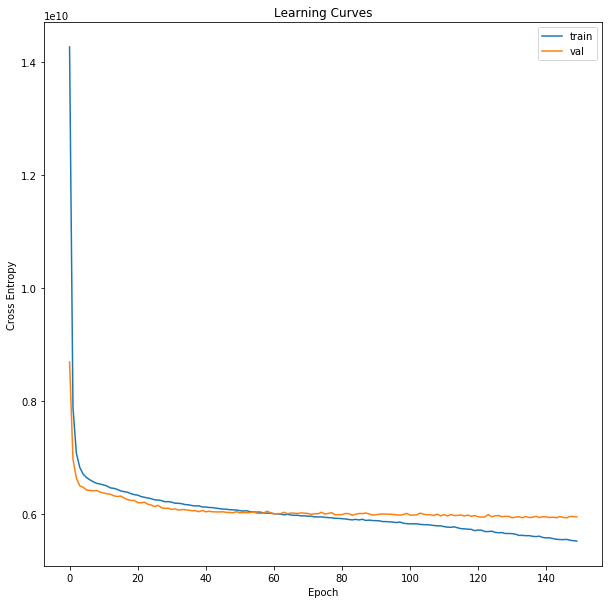

In [45]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

In [46]:
# Evaluation des Regressionsmodells
error = seq_model.evaluate(X_test, y_test)

594/594 [==============================] - 0s 704us/step - loss: 5950942720.0000 - mse: 5950942720.0000 - rmse: 77142.3516 - mae: 36326.8203


In [47]:
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % 
      (error[1], error[2], error[3]))

MSE: 5950942720.000, RMSE: 77142.352, MAE: 36326.820


Text(0, 0.5, 'predicted values (test data)')

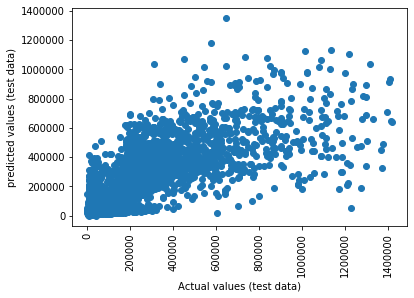

In [48]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Test Data

predictions= seq_model.predict(X_test)
plt.plot(y_test, predictions, 'o')
plt.xlabel('Actual values (test data)')
plt.xticks(rotation=90)
plt.ylabel('predicted values (test data)')

In [49]:
# Berechnung des R2-Scores (Bestimmtheitsmaß)
r2_seq = r2_score(y_test, predictions)
r2_seq

0.6835925744432714

In [50]:
# Berechnung des adjustierten R2-Scores (adj. Bestimmtheitsmaß)
adj_r2_seq = 1-(1-r2_seq)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))

In [51]:
print(('%.6f \t %.6f \t %.0f  \t %.0f \t %.0f' % 
      (r2_seq, adj_r2_seq, error[2], error[1], error[3])).replace('.', ','))

0,683593 	 0,683292 	 77142  	 5950942720 	 36327


Text(0, 0.5, 'predicted values (train data)')

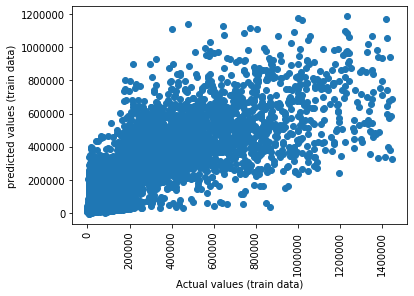

In [52]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Training Data
train_predictions = seq_model.predict(X_train)
plt.plot(y_train, train_predictions, 'o')
plt.xlabel('Actual values (train data)')
plt.xticks(rotation=90)
plt.ylabel('predicted values (train data)')

In [53]:
predictions = predictions.flatten()

In [54]:
train_predictions = train_predictions.flatten()

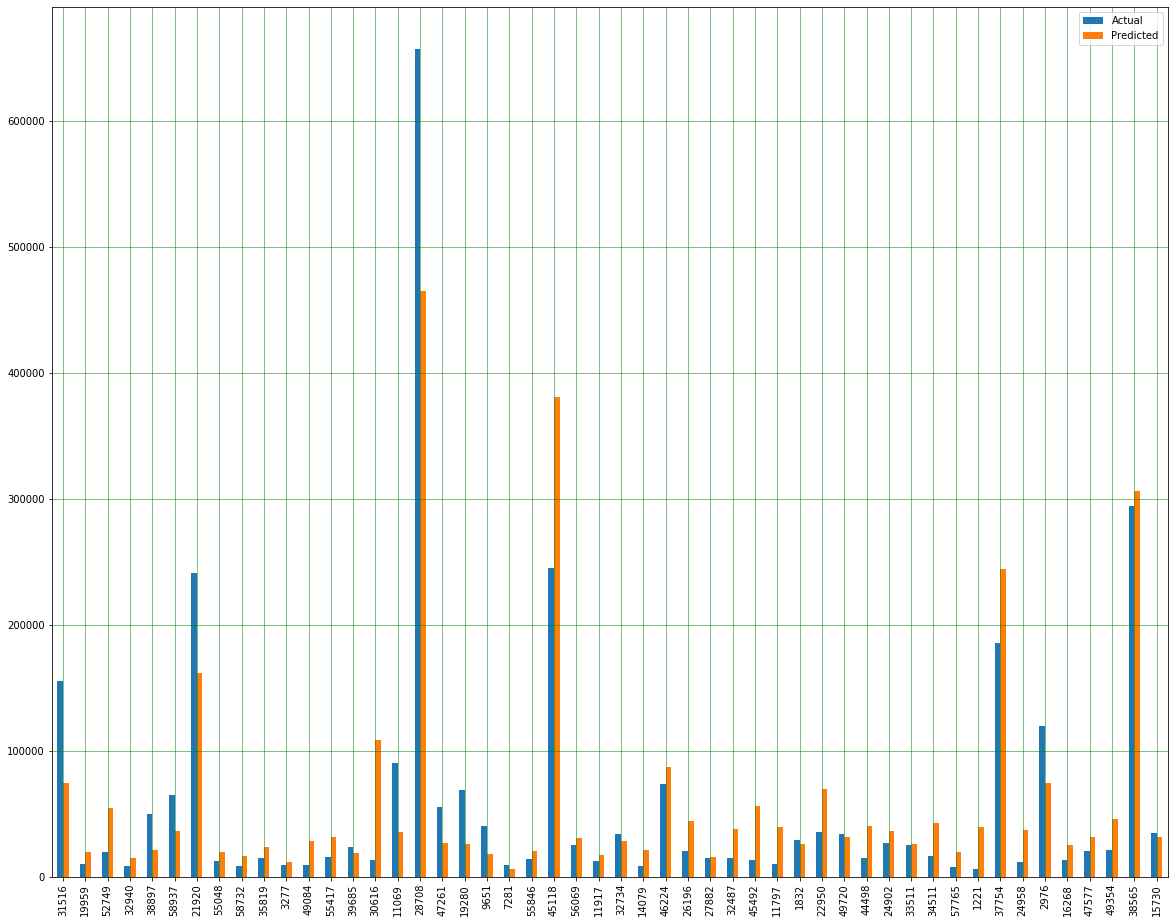

In [55]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

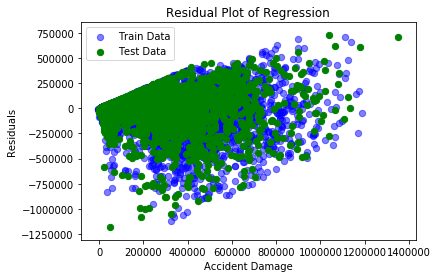

In [56]:
# Differenzen zwischen vorhergesagten und tatsächlichen Werten
plt.scatter(train_predictions, train_predictions - y_train, c='b', s=40, alpha=0.5, label='Train Data')
plt.scatter(predictions, predictions - y_test, c='g', s=40, label='Test Data')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residual Plot of Regression')
plt.ylabel('Residuals')
plt.xlabel('Accident Damage')
plt.legend()
plt.show()

## Functional API Regression Model with Keras

In [57]:
x_in = Input(shape=(n_features,))
dense = Dense(1024, activation=activation)
x = dense(x_in)
x = Dropout(dropout)(x)
x = Dense(512, activation=activation)(x)
#x = Dense(256, activation=activation)(x)
#x = Dropout(dropout)(x)
#x = Dense(128, activation=activation)(x)
#x = Dropout(dropout)(x)
#x = Dense(64, activation=activation)(x)
#x = Dropout(dropout)(x)
x_out = Dense(1)(x)
func_model = Model(inputs=x_in, outputs=x_out)

In [58]:
func_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              49152     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 574,465
Trainable params: 574,465
Non-trainable params: 0
_________________________________________________________________


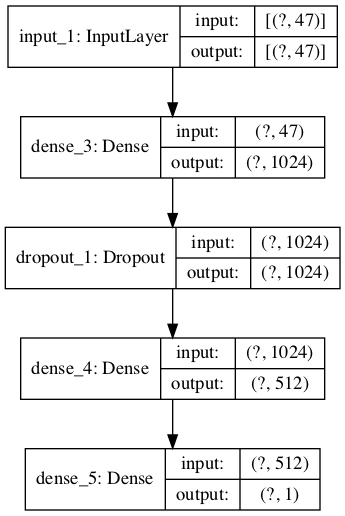

In [59]:
plot_model(func_model, 'Images/Functional API Regression Model.png', show_shapes=True)

In [60]:
func_model.compile(optimizer=opt, loss='mse', metrics=metrics)

In [61]:
es = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
func_history = func_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, batch_size=32)

Epoch 1/150
1385/1385 [==============================] - 6s 4ms/step - loss: 8973685760.0000 - mse: 8973685760.0000 - rmse: 89815.6250 - mae: 44677.9531 - val_loss: 6781975552.0000 - val_mse: 6781975552.0000 - val_rmse: 82352.7500 - val_mae: 40131.5586
Epoch 2/150
1385/1385 [==============================] - 6s 4ms/step - loss: 6867386880.0000 - mse: 6867386880.0000 - rmse: 82869.6953 - mae: 38867.7656 - val_loss: 6484096512.0000 - val_mse: 6484096512.0000 - val_rmse: 80523.8906 - val_mae: 37538.9570
Epoch 3/150
1385/1385 [==============================] - 6s 4ms/step - loss: 6690936320.0000 - mse: 6690936320.0000 - rmse: 81798.1406 - mae: 38267.4297 - val_loss: 6424044032.0000 - val_mse: 6424044032.0000 - val_rmse: 80150.1328 - val_mae: 37751.2461
Epoch 4/150
1385/1385 [==============================] - 6s 4ms/step - loss: 6603603968.0000 - mse: 6603603968.0000 - rmse: 81262.5625 - mae: 38082.4648 - val_loss: 6401800192.0000 - val_mse: 6401800192.0000 - val_rmse: 80011.2500 - val_mae:

1385/1385 [==============================] - 6s 4ms/step - loss: 6074715648.0000 - mse: 6074715648.0000 - rmse: 77940.4609 - mae: 36551.6289 - val_loss: 6030956032.0000 - val_mse: 6030956032.0000 - val_rmse: 77659.2266 - val_mae: 36106.1953
Epoch 34/150
1385/1385 [==============================] - 6s 4ms/step - loss: 6067170304.0000 - mse: 6067170304.0000 - rmse: 77892.0391 - mae: 36533.5234 - val_loss: 6050484736.0000 - val_mse: 6050484736.0000 - val_rmse: 77784.8594 - val_mae: 35832.0664
Epoch 35/150
1385/1385 [==============================] - 6s 4ms/step - loss: 6041096704.0000 - mse: 6041096704.0000 - rmse: 77724.4922 - mae: 36513.2109 - val_loss: 6027042816.0000 - val_mse: 6027042816.0000 - val_rmse: 77634.0312 - val_mae: 36166.4492
Epoch 36/150
1385/1385 [==============================] - 6s 4ms/step - loss: 6059227136.0000 - mse: 6059227136.0000 - rmse: 77841.0391 - mae: 36455.9648 - val_loss: 6013867008.0000 - val_mse: 6013867008.0000 - val_rmse: 77549.1250 - val_mae: 36006.42

1385/1385 [==============================] - 6s 4ms/step - loss: 5879934976.0000 - mse: 5879934976.0000 - rmse: 76680.7344 - mae: 36147.4062 - val_loss: 6046007296.0000 - val_mse: 6046007296.0000 - val_rmse: 77756.0781 - val_mae: 36778.8867
Epoch 66/150
1385/1385 [==============================] - 6s 4ms/step - loss: 5879914496.0000 - mse: 5879914496.0000 - rmse: 76680.6016 - mae: 36154.8281 - val_loss: 6013698048.0000 - val_mse: 6013698048.0000 - val_rmse: 77548.0391 - val_mae: 36483.6289
Epoch 67/150
1385/1385 [==============================] - 6s 4ms/step - loss: 5874526720.0000 - mse: 5874526720.0000 - rmse: 76645.4609 - mae: 36142.7344 - val_loss: 6026588160.0000 - val_mse: 6026588160.0000 - val_rmse: 77631.1016 - val_mae: 36541.2266
Epoch 68/150
1385/1385 [==============================] - 6s 4ms/step - loss: 5866720256.0000 - mse: 5866720256.0000 - rmse: 76594.5156 - mae: 36144.6680 - val_loss: 6022707200.0000 - val_mse: 6022707200.0000 - val_rmse: 77606.1016 - val_mae: 35616.51

1385/1385 [==============================] - 6s 4ms/step - loss: 5675808256.0000 - mse: 5675808256.0000 - rmse: 75337.9609 - mae: 35673.1172 - val_loss: 6031899648.0000 - val_mse: 6031899648.0000 - val_rmse: 77665.3047 - val_mae: 35862.7852
Epoch 98/150
1385/1385 [==============================] - 6s 4ms/step - loss: 5684995584.0000 - mse: 5684995584.0000 - rmse: 75398.9062 - mae: 35698.2148 - val_loss: 6016955904.0000 - val_mse: 6016955904.0000 - val_rmse: 77569.0391 - val_mae: 36890.3242
Epoch 99/150
1385/1385 [==============================] - 6s 4ms/step - loss: 5656944640.0000 - mse: 5656944640.0000 - rmse: 75212.6641 - mae: 35650.4102 - val_loss: 6019282944.0000 - val_mse: 6019282944.0000 - val_rmse: 77584.0391 - val_mae: 35935.6680
Epoch 100/150
1385/1385 [==============================] - 6s 4ms/step - loss: 5661919232.0000 - mse: 5661919232.0000 - rmse: 75245.7266 - mae: 35620.5234 - val_loss: 6003176960.0000 - val_mse: 6003176960.0000 - val_rmse: 77480.1719 - val_mae: 36563.3

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(func_history.history['loss'], label='train')
plt.plot(func_history.history['val_loss'], label='val')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend()
plt.show()

In [ ]:
# Evaluation des Regressionsmodells
error_func = func_model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % 
      (error_func[1], error_func[2], error_func[3]))

In [ ]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Test Data
func_predictions=func_model.predict(X_test)
plt.plot(y_test, func_predictions, 'o')
plt.xlabel('Actual values (test data)')
plt.xticks(rotation=90)
plt.ylabel('predicted values (test data)')

In [ ]:
# Berechnung des R2-Scores (Bestimmtheitsmaß)
r2_func = r2_score(y_test, func_predictions)
r2_func

In [ ]:
# Berechnung des adjustierten R2-Scores (adj. Bestimmtheitsmaß)
adj_r2_func = 1-(1-r2_func)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))
adj_r2_func

In [ ]:
print(('%.6f \t %.6f \t %.0f  \t %.0f \t %.0f' % 
      (r2_func, adj_r2_func, error_func[2], error_func[1], error_func[3])).replace('.', ','))

In [ ]:
# Scatter Plot mit den tatsächlichen und den vorhergesagten Daten für die Training Data
func_train_predictions=func_model.predict(X_train)
plt.plot(y_train, func_train_predictions, 'o')
plt.xlabel('Actual values (train data)')
plt.xticks(rotation=90)
plt.ylabel('predicted values (train data)')

In [ ]:
func_predictions = func_predictions.flatten()

In [ ]:
func_train_predictions = func_train_predictions.flatten()

In [ ]:
pred = pd.DataFrame({'Actual': y_test, 'Predicted': func_predictions})
pred1 = pred.sample(50)

pred1.plot(kind='bar',figsize=(20,16))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
# Differenzen zwischen vorhergesagten und tatsächlichen Werten
plt.scatter(func_train_predictions, func_train_predictions - y_train, c='b', s=40, alpha=0.5, label='Train Data')
plt.scatter(func_predictions, func_predictions - y_test, c='g', s=40, label='Test Data')
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residual Plot of Regression')
plt.ylabel('Residuals')
plt.xlabel('Accident Damage')
plt.legend()
plt.show()

## Polynomial Regression with Scikit-Learn
* Polynomial Regression
* Polynomial Regression with Lasso => Lasso Regression schrumpft Koeffizienten um absoluten Wert -> ausselektieren.
* Polynomial Regression with Ridge (Ridge Regression or Tikhonov regularization) => Ridge Regression schrumpft Koeffizienten um relativen Wert.

In [ ]:
def poly_regression(X_train, X_test, Y_train, Y_test, reg):
    reg.fit(X_train, Y_train)
    y_pred = reg.predict(X_test)
    coef = reg.coef_
    intercept = reg.intercept_
    r2 = r2_score(Y_test, y_pred)
    MSA = mean_absolute_error(Y_test, y_pred) 
    MSE = mean_squared_error(Y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MSLE = mean_squared_log_error(Y_test, y_pred)
    
    return [r2, MSA, MSE, RMSE, MSLE]

In [ ]:
def create_polynomial_regression_model(degree, reg):  
    poly_feat = PolynomialFeatures(degree=degree)
    X_train_poly = poly_feat.fit_transform(X_train)
    poly = reg[1].fit(X_train_poly, y_train)
    y_train_pred = poly.predict(X_train_poly)
    y_pred = poly.predict(poly_feat.fit_transform(X_test))
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1-(1-r2)*((len(X_test)-1)/(len(X_test)-(len(cat)+len(con))))
    MSA = mean_absolute_error(y_test, y_pred) 
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    #MSLE = mean_squared_log_error(y_test, y_pred)
    
    #print("The model performance with %s and a degree of %s" % (reg[0], degree))
    #print("R2 score of test set is %s" % (r2))
    #print("RMSE score of test set is %s" % (RMSE))
    #print("MSE score of test set is %s" % (MSE))
    #print("-------------------------------------------")
    #print(("%s \t %s \t %.6f \t %.0f \t %.4f" % (reg[0], degree, r2, RMSE, MSE)).replace('.', ','))
    print(("%.6f \t %.6f \t %.0f \t %.0f \t %.0f" % (r2, adj_r2, RMSE, MSE, MAE)).replace('.', ','))
    return [r2, adj_r2, MSA, MSE, RMSE, reg[1].coef_]

In [ ]:
#poly = PolynomialFeatures(n_features)

In [ ]:
degrees = [10, 15, 20]
poly_models = [["Lasso", Lasso()], ["ElasticNet", ElasticNet()]]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#for mod in poly_models:
#    for deg in degrees:
#        poly_reg = create_polynomial_regression_model(deg, mod)

In [ ]:
#poly_reg = poly_regression(X_train_poly, Y_train, X_test_poly, Y_test, LinearRegression())

In [ ]:
#poly_lasso_reg = poly_regression(X_train_poly, Y_train, X_test_poly, Y_test, Lasso())

In [ ]:
#poly_ridge_reg = poly_regression(X_train_poly, Y_train, X_test_poly, Y_test, Ridge())